In [1]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 107.8 MB/s eta 0:00:0000:01


In [2]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

3.1.3


In [4]:
# Read into spark df

%time licenses_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/licenses")
%time languages_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")

CPU times: user 3.5 ms, sys: 1.01 ms, total: 4.52 ms
Wall time: 496 ms


CPU times: user 5.63 ms, sys: 444 µs, total: 6.08 ms
Wall time: 2.42 s


## Re-read from save

In [2]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/commits_filtered.parquet"
commits_spDf = spark.read.parquet(bucket_write)

In [3]:
from pyspark.sql.functions import explode, col

# Step 1: Explode repo_name in commits_spDf
commits_exploded = commits_spDf.withColumn("repo_name_exploded", explode(col("repo_name")))

commits_exploded.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

In [7]:
licenses_spDf.printSchema()
languages_spDf.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



In [9]:
from pyspark.sql.functions import col, count

# Count repositories for each license
license_distribution = licenses_spDf.groupBy("license").agg(count("repo_name").alias("repo_count"))

# Sort in descending order
license_distribution = license_distribution.orderBy(col("repo_count").desc())

# Show the distribution
license_distribution.limit(5)

license,repo_count
mit,1696489
apache-2.0,495134
gpl-2.0,341505
gpl-3.0,340407
bsd-3-clause,150701


In [10]:
licences_pd = license_distribution.toPandas()

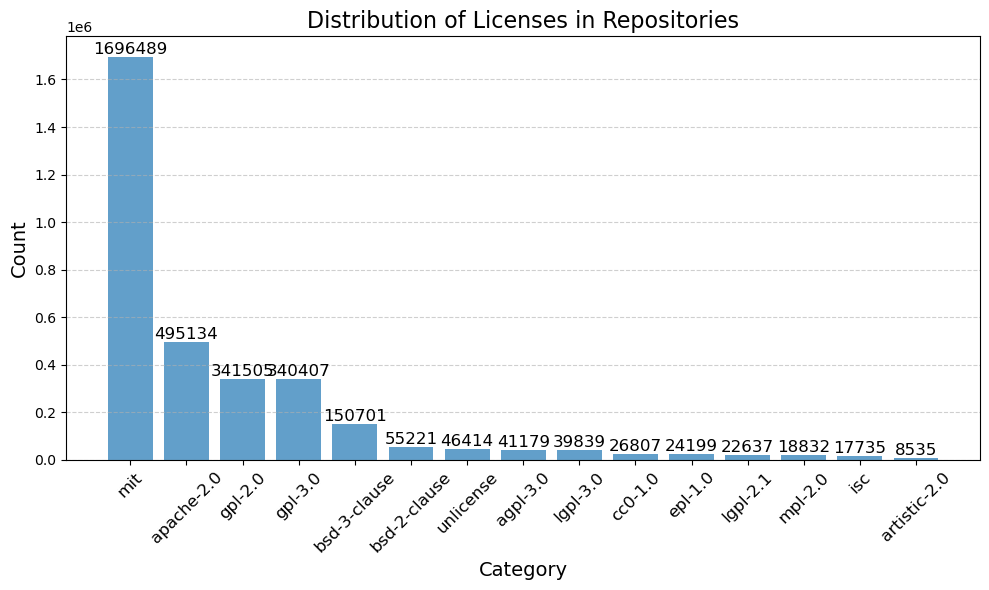

In [12]:
plt.figure(figsize=(10, 6))
bars = plt.bar(licences_pd['license'], licences_pd['repo_count'], alpha=0.7)

# Add data points on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title('Distribution of Licenses in Repositories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
from pyspark.sql.functions import explode

# Explode the language array in languages_spDf
languages_exploded = languages_spDf.withColumn("language_name", explode(col("language.name")))

# Join licenses and languages
licenses_languages_df = licenses_spDf.join(languages_exploded, on="repo_name", how="inner")

# Show a sample of the merged data
licenses_languages_df.select("repo_name", "license", "language_name").limit(5)

repo_name,license,language_name
0-0-1/cogbot,mit,Python
0-Eclipse-0/SaltB...,gpl-2.0,Batchfile
0-Eclipse-0/Silve...,gpl-2.0,CSS
0-k/what-about,apache-2.0,Python
0-mb/pg-lb,mit,JavaScript


In [15]:
# Count occurrences of each language-license pair
language_license_distribution = licenses_languages_df.groupBy("language_name", "license") \
    .agg(count("repo_name").alias("repo_count"))

# Sort by repo_count in descending order
language_license_distribution = language_license_distribution.orderBy(col("repo_count").desc())

# Show the top associations
language_license_distribution.limit(5)


language_name,license,repo_count
JavaScript,mit,685287
CSS,mit,458715
HTML,mit,449004
Ruby,mit,265248
Shell,mit,245673


In [16]:
combo_count = language_license_distribution.toPandas()

In [25]:
combo_count['language_license'] = combo_count['language_name'] + "_" + combo_count['license']

In [26]:
top_combo = combo_count.head(500)

In [27]:
# Top 500 combinations have 118 unique languages used
top_combo['language_name'].nunique()

118

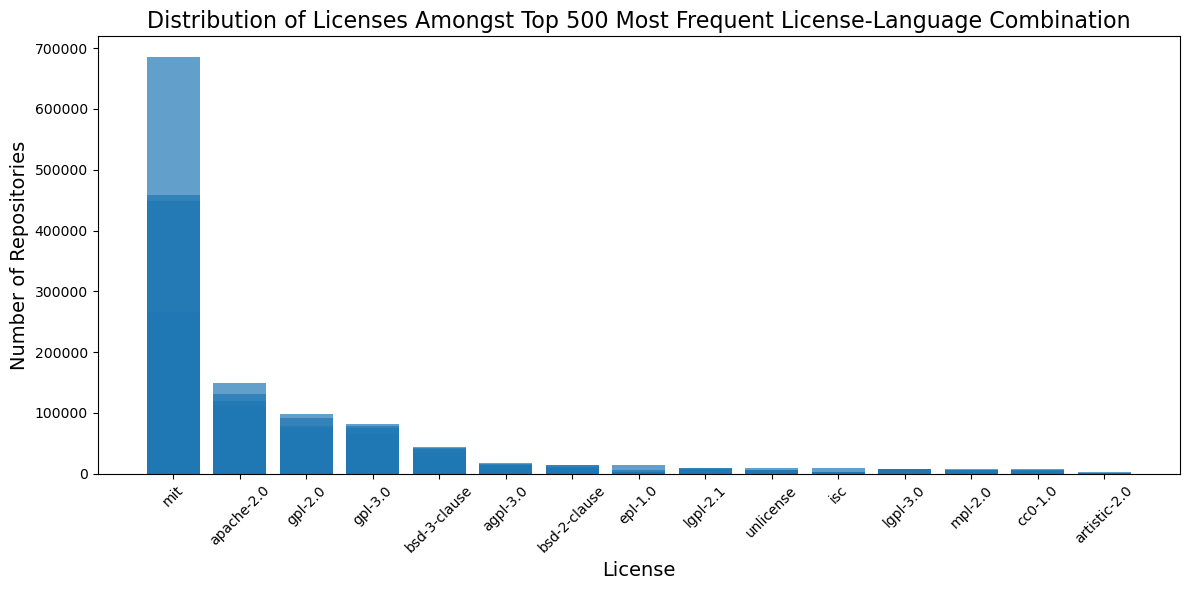

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(top_combo['license'], top_combo['repo_count'], alpha=0.7)
plt.title('Distribution of Licenses Amongst Top 500 Most Frequent License-Language Combination', fontsize=16)
plt.xlabel('License', fontsize=14)
plt.ylabel('Number of Repositories', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

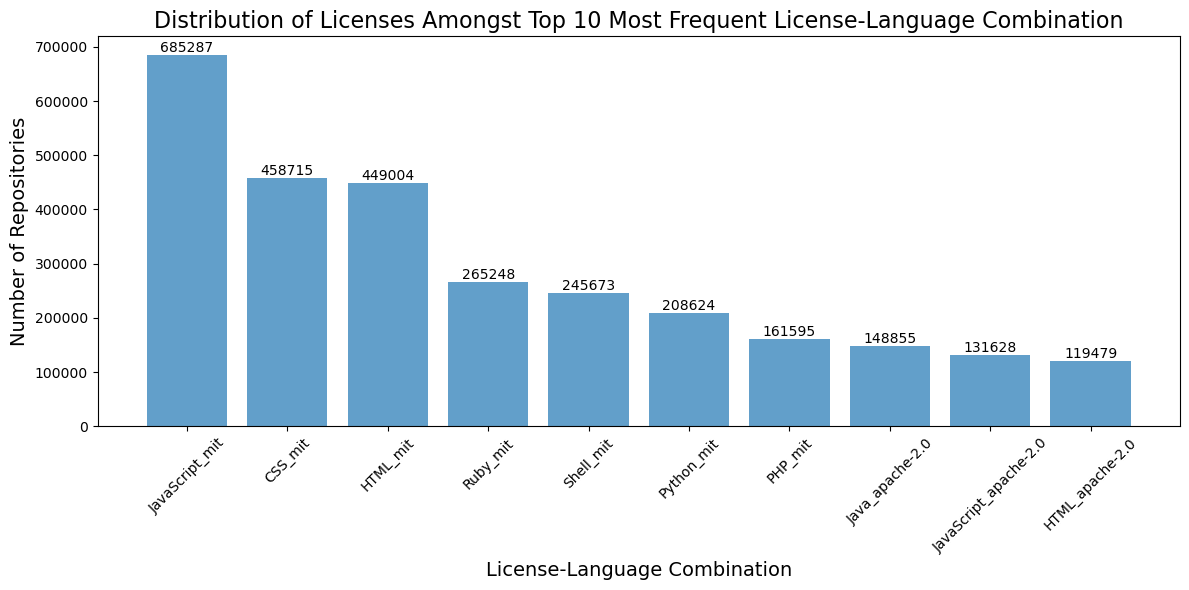

In [32]:
plt.figure(figsize=(12, 6))
bars = plt.bar(top_combo_top['language_license'], top_combo_top['repo_count'], alpha=0.7)

# Add data points on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        height,                             # Height of the bar
        f'{int(height)}',                   # Text to display
        ha='center', va='bottom', fontsize=10  # Alignment and font size
    )

# Add labels and title
plt.title('Distribution of Licenses Amongst Top 10 Most Frequent License-Language Combination', fontsize=16)
plt.xlabel('License-Language Combination', fontsize=14)
plt.ylabel('Number of Repositories', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

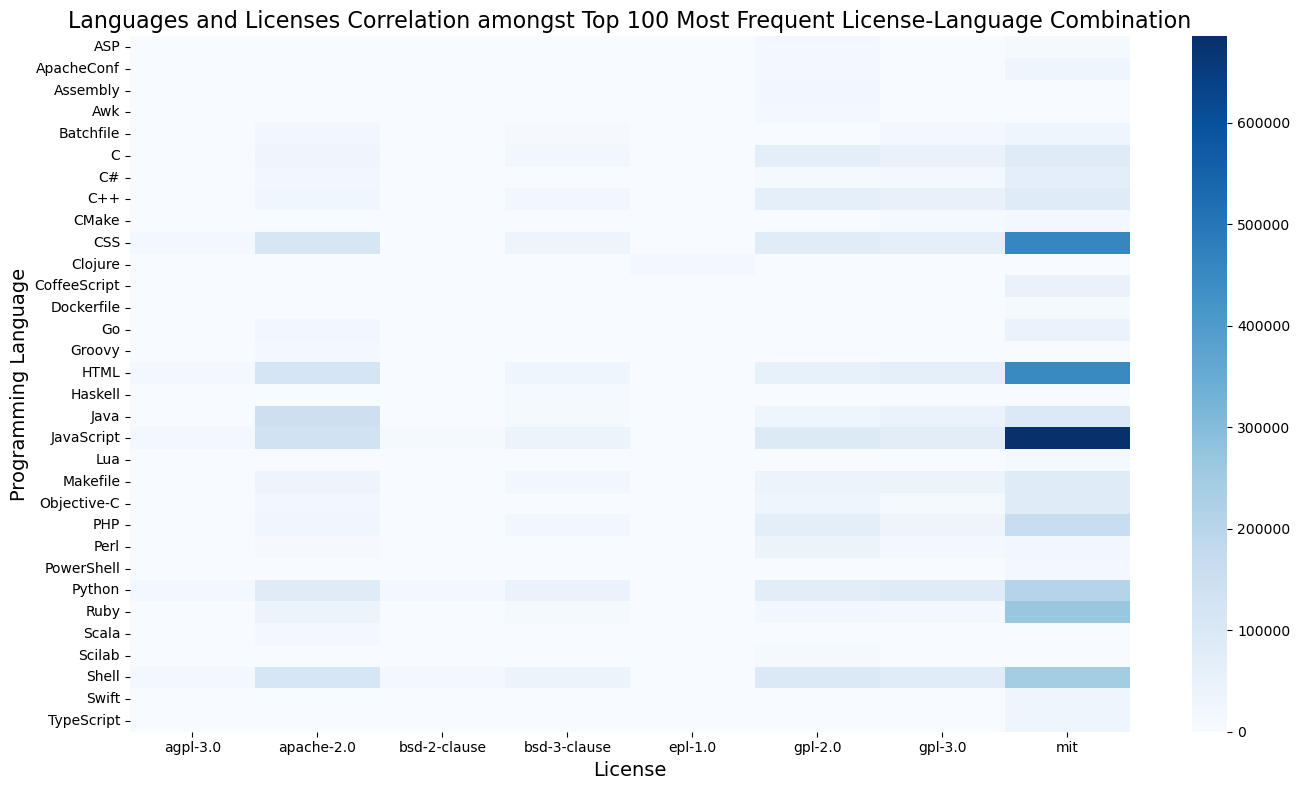

In [37]:
import seaborn as sns

top_combo_top = top_combo.head(100)
# Pivot for heatmap
heatmap_data = top_combo_top.pivot(index="language_name", columns="license", values="repo_count").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=False, cmap="Blues", cbar=True)
plt.title('Languages and Licenses Correlation amongst Top 100 Most Frequent License-Language Combination', fontsize=16)
plt.xlabel('License', fontsize=14)
plt.ylabel('Programming Language', fontsize=14)
plt.tight_layout()
plt.show()


In [1]:
# Top Language

In [7]:
languages_repo = languages_spDf.join(
    commits_exploded,
    languages_spDf["repo_name"] == commits_exploded["repo_name_exploded"],
    how="inner"
)
languages_repo.printSchema()                          

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: 

In [13]:
from pyspark.sql.functions import col, explode, expr, from_unixtime

language_repo_name = languages_repo.select(col('repo_name_exploded'),
                     explode('language').alias("language_detail"),
                     from_unixtime(col('committer.date.seconds')).alias('commit_time')
                     ).select(col("repo_name_exploded"),
                              col('commit_time'),
                              col("language_detail.name").alias("language_name")
)


In [14]:
language_repo_name.limit(5).show()

+------------------+-------------------+-------------+
|repo_name_exploded|        commit_time|language_name|
+------------------+-------------------+-------------+
|      0-0-1/cogbot|2017-01-19 07:31:55|       Python|
|      0-0-1/cogbot|2017-02-04 17:58:19|       Python|
|      0-0-1/cogbot|2017-01-19 19:20:04|       Python|
|      0-0-1/cogbot|2017-05-03 05:07:40|       Python|
|      0-0-1/cogbot|2017-08-19 21:50:40|       Python|
+------------------+-------------------+-------------+



In [12]:
language_repo_name.printSchema()

root
 |-- repo_name_exploded: string (nullable = true)
 |-- commit_time: long (nullable = true)
 |-- language_name: string (nullable = true)



In [16]:
%time rows = language_repo_name.count()
print(f"Total rows {rows}")

CPU times: user 919 ms, sys: 219 ms, total: 1.14 s
Wall time: 11min 59s
Total rows 47109720919


In [ ]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.parquet"

# Write the DataFrame to GCS as a Parquet file
language_repo_name.write \
    .mode("overwrite") \
    .parquet(bucket_write)

print(f"DataFrame successfully written to {bucket_write}")

DataFrame successfully written to gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.parquet


In [4]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.parquet"

language_repo_name = spark.read.parquet(bucket_write)

In [6]:
from pyspark.sql.functions import year, count, col

# Extract year from commit_time
popularity_over_time = language_repo_name.withColumn("year", year(col("commit_time"))).groupBy(
    "language_name", "year"
).agg(
    count("*").alias("count")
).orderBy("year", col("count").desc())


In [ ]:
# Show results
popularity_over_time.count()

In [ ]:
yearly_count = popularity_over_time.toPandas()

In [ ]:
# Convert to Pandas

# Plot using Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Example plot
plt.figure(figsize=(15, 10))
sns.lineplot(data=yearly_count, x="year", y="count", hue="language_name", marker="o")
plt.title("Programming Language Popularity Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Language")
plt.show()

In [11]:
yearly_count.head(5)

,language_name,year,count
0,Shell,1970,6235
1,JavaScript,1970,6051
2,CSS,1970,5897
3,HTML,1970,5809
4,PHP,1970,5522


In [12]:
yearly_count.to_csv("gs://msca-bdp-students-bucket/shared_data/xiuan/yearly_count.csv")

In [22]:
# Group by language_name and sum the counts
language_sum = yearly_count.groupby('language_name')['count'].sum()

# Sort the summed values in descending order and get the top 10
top_languages = language_sum.sort_values(ascending=False).head(10)

# Display the results
print(top_languages)

language_name
Shell           3268926654
Python          2889366274
C               2664211509
C++             2610573020
Perl            2538969992
Objective-C     2410865980
Assembly        2300939318
Makefile        2211510805
Awk             2087983079
UnrealScript    1881639835
Name: count, dtype: int64


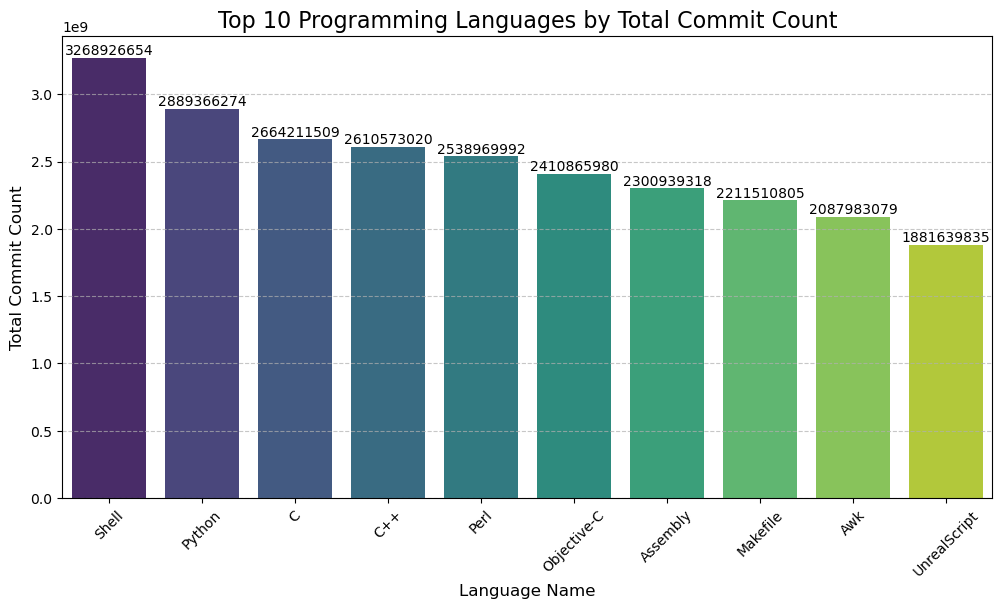

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the bar chart
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=top_languages.index, y=top_languages.values, palette="viridis")

# Annotate each bar with its height
for bar in barplot.patches:
    height = bar.get_height()
    barplot.text(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        height,                             # Height of the bar
        f'{int(height)}',                   # Text to display
        ha='center', va='bottom', fontsize=10  # Alignment and font size
    )

# Customize the chart
plt.title("Top 10 Programming Languages by Total Commit Count", fontsize=16)
plt.xlabel("Language Name", fontsize=12)
plt.ylabel("Total Commit Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


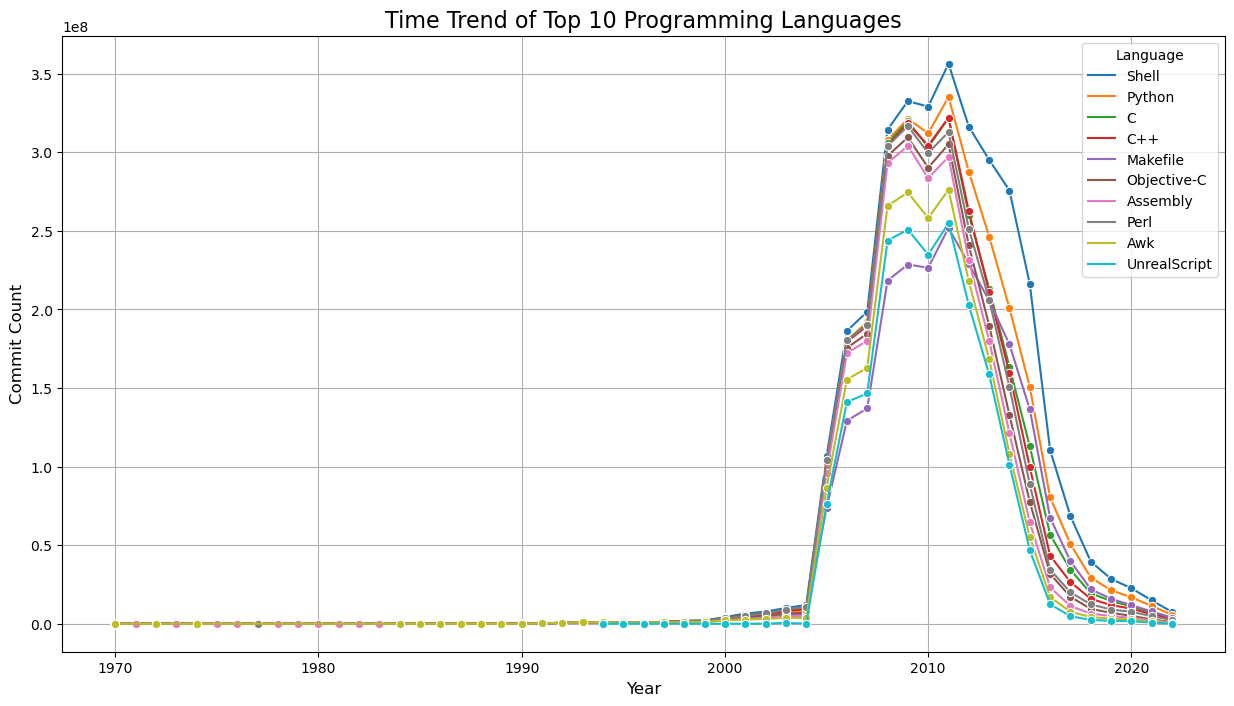

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by language_name to get the top 10 languages
language_sum = yearly_count.groupby('language_name')['count'].sum()
top_languages = language_sum.sort_values(ascending=False).head(10).index

# Filter the original DataFrame for only the top 10 languages
top_languages_trend = yearly_count[yearly_count['language_name'].isin(top_languages)]

# Plot the time trend
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=top_languages_trend,
    x="year", 
    y="count", 
    hue="language_name", 
    marker="o"
)

# Customize the plot
plt.title("Time Trend of Top 10 Programming Languages", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Commit Count", fontsize=12)
plt.legend(title="Language", fontsize=10)
plt.grid(True)
plt.show()

In [24]:
top_languages.index

Index(['Shell', 'Python', 'C', 'C++', 'Perl', 'Objective-C', 'Assembly',
       'Makefile', 'Awk', 'UnrealScript'],
      dtype='object', name='language_name')